In [247]:
import warnings
warnings.filterwarnings('ignore')

/Users/vipultanwar/Documents/kite/kite/lib/python3.8/site-packages/eikon/time_series.py:282: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  datapoints = pd.np.array(timeseries['dataPoints'])
/Users/vipultanwar/Documents/kite/kite/lib/python3.8/site-packages/eikon/time_series.py:284: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  timestamps = pd.np.array([tz_replacer(value) for value in datapoints[:, timestamp_index]],
/Users/vipultanwar/Documents/kite/kite/lib/python3.8/site-packages/eikon/time_series.py:286: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  datapoints = pd.np.delete(datapoints, pd.np.s_[timestamp_index],
/Users/vipultanwar/Documents/kite/kite/lib/python3.8/site-packages/eikon/time_series.py:209: FutureWarning: T

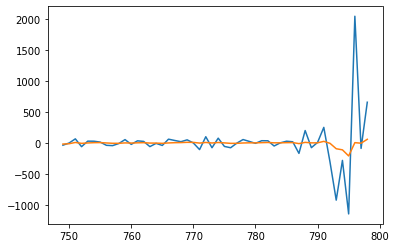

In [245]:
import eikon as ek

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pykalman import KalmanFilter
from datetime import datetime
from numpy import log, polyfit, sqrt, std, subtract
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm


ek.set_app_key('APP_KEY')

df = ek.get_timeseries(rics=['MSDc1','MSDc3'],fields=['CLOSE'],start_date='2017-01-01',end_date='2020-04-23',interval='hour')

df.dropna(inplace=True)

df['MSDc1 ret'] = df['MSDc1'] - df['MSDc1'].shift(1)
df['MSDc3 ret'] = df['MSDc3'] - df['MSDc3'].shift(1)

df['MSDc1 ret perc'] = df['MSDc1 ret']/df['MSDc1'].shift(1)
df['MSDc3 ret perc'] = df['MSDc3 ret']/df['MSDc3'].shift(1)

df.dropna(inplace=True)

df['return perc gap'] = df['MSDc1 ret perc'] - df['MSDc3 ret perc']



df.reset_index(inplace=True)

df['ret gap'] = df['MSDc1 ret'] - (1*df['MSDc3 ret'])
df['ret gap avg'] = KalmanFilterAverage(df['ret gap'])
plt.plot(df['ret gap'][-50:])
plt.plot(KalmanFilterAverage(df['ret gap'][-50:]))
plt.show()

df['Excess ret gap'] = df['ret gap'] - df['ret gap avg'] 


df['spread'] = df['MSDc1'] - (1*df['MSDc3'])

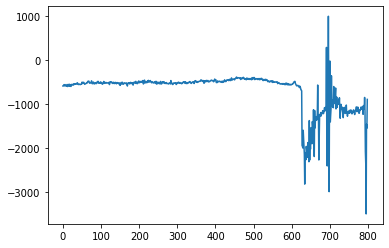

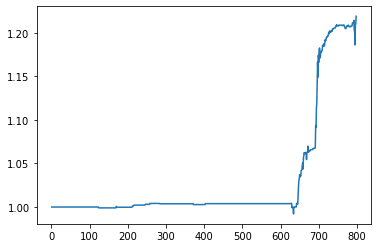

,x,y,spread,zScore,hr,costs,long entry,long exit,num units long,short entry,short exit,num units short,numUnits,spread pct ch,port rets,cum rets
794,35840.0,38200.0,-2360.0,-170.046927,-1,-75,False,False,1.0,False,False,0.0,1.0,-0.002782,-0.002782,1.200619
795,34881.0,38384.0,-3503.0,-933.873544,-1,-75,False,False,1.0,False,False,0.0,1.0,-0.014577,-0.014577,1.186041
796,43556.0,45018.0,-1462.0,2036.083353,-1,-75,False,True,0.0,True,False,-1.0,-1.0,0.023890,0.023890,1.209931
797,41650.0,43200.0,-1550.0,-84.077959,-1,-75,True,False,1.0,False,True,0.0,1.0,-0.000153,0.000153,1.210084
798,40991.0,41885.0,-894.0,597.147009,-1,-75,False,True,0.0,True,False,-1.0,-1.0,0.008820,0.008820,1.218905


In [248]:
entryZscore = 50
exitZscore = 5
df1 = df[['MSDc1','MSDc3','spread','Excess ret gap']]
df1.columns = ['x','y','spread','zScore']
df1['hr'] = -1

df1['costs'] = -75

df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore)) 
df1['num units long'] = np.nan 
df1.loc[df1['long entry'],'num units long'] = 1 
df1.loc[df1['long exit'],'num units long'] = 0 
df1['num units long'][0] = 0 
df1['num units long'] = df1['num units long'].fillna(method='pad') #set up num units short 
df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
df1.loc[df1['short entry'],'num units short'] = -1
df1.loc[df1['short exit'],'num units short'] = 0
df1['num units short'][0] = 0
df1['num units short'] = df1['num units short'].fillna(method='pad')

df1['numUnits'] = df1['num units long'] + df1['num units short']
df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1) - df1['costs']) / ((df1['y'] * abs(df1['hr'])) + df1['x'])
df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

df1['cum rets'] = df1['port rets'].cumsum()
df1['cum rets'] = df1['cum rets'] + 1

df1.tail()

plt.plot(df1['spread'])
plt.show()

plt.plot(df1['cum rets'])

plt.show()

df1.tail()

In [234]:
df1.head()

,x,y,spread,zScore,hr,costs,long entry,long exit,num units long,short entry,short exit,num units short,numUnits,spread pct ch,port rets,cum rets
0,31784.0,31866.0,-82.0,3.500000,-1,-50,False,False,0.0,False,False,0.0,0.0,NaN,NaN,NaN
1,31782.0,31864.0,-82.0,-2.317881,-1,-50,False,False,0.0,False,False,0.0,0.0,0.000786,0.0,1.0
2,31796.0,31869.0,-73.0,4.957987,-1,-50,False,False,0.0,False,False,0.0,0.0,0.000927,0.0,1.0
3,31793.0,31879.0,-86.0,-13.439843,-1,-50,False,False,0.0,False,False,0.0,0.0,0.000581,0.0,1.0
4,31800.0,31863.0,-63.0,18.471190,-1,-50,False,False,0.0,False,False,0.0,0.0,0.001147,0.0,1.0


In [208]:
KalmanFilterAverage(df['ret gap']).min()

-231.0141330438497

In [99]:
def half_life(spread):
  spread_lag = spread.shift(1)
  spread_lag.iloc[0] = spread_lag.iloc[1]
  spread_ret = spread - spread_lag
  spread_ret.iloc[0] = spread_ret.iloc[1]
  spread_lag2 = sm.add_constant(spread_lag)
  model = sm.OLS(spread_ret,spread_lag2)
  res = model.fit()
  print(res.params[1])
  halflife = int(round(-np.log(2) / res.params[1],0))

  if halflife <= 0:
    halflife = 1
  return halflife

In [100]:
print(half_life(df['return perc gap']))

-1.085897991765291
1


In [17]:
result = sm.tsa.stattools.coint(df['MMIc1 ret'], df['MSDc1 ret']) # get conintegration
pvalue = result[1] # get the pvalue


In [23]:
from pykalman import KalmanFilter

def KalmanFilterAverage(x):
  # Construct a Kalman filter

  kf = KalmanFilter(transition_matrices = [1],
     observation_matrices = [1],
     initial_state_mean = 0,
     initial_state_covariance = 1,
     observation_covariance=1,
     transition_covariance=.01)

  # Use the observed values of the price to get a rolling mean
  state_means, _ = kf.filter(x.values)
  state_means = pd.Series(state_means.flatten(), index=x.index)
  return state_means
# Kalman filter regression


def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, initial_state_mean=[0,0],initial_state_covariance=np.ones((2, 2)),transition_matrices=np.eye(2),observation_matrices=obs_mat, observation_covariance=2,transition_covariance=trans_cov)
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

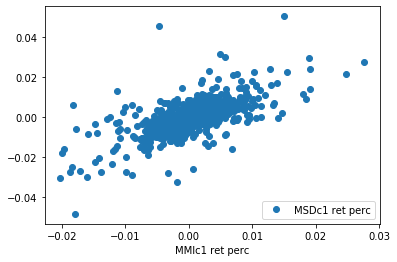

In [41]:
%matplotlib inline

df.plot(x='MMIc1 ret perc', y='MSDc1 ret perc', style='o')  

plt.show()

In [42]:
hr = KalmanFilterRegression(KalmanFilterAverage(df['MMIc1 ret perc']),KalmanFilterAverage(df['MSDc1 ret perc']))

hr = hr[:,0]

In [27]:
plt.clf()

<Figure size 432x288 with 0 Axes>

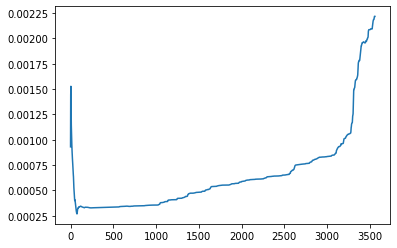

In [43]:

plt.plot(hr)
plt.show()